# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

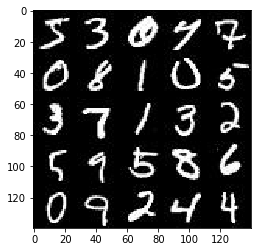

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

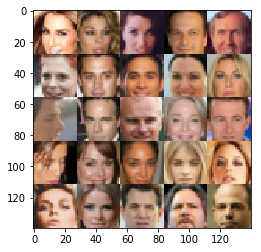

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(tf.float32, shape=[])

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    with tf.variable_scope("discriminator", reuse=reuse):
        # Image size 28x28x1 or 28x28x3
        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.nn.relu(conv)
        #conv = tf.maximum(alpha * conv, conv)
        # Image size 14x14x64
        
        conv = tf.layers.conv2d(images, 512, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.nn.relu(conv)
        #conv = tf.maximum(alpha * conv, conv)
        # Image size 7x7x256
        
        logits = tf.reshape(conv, [-1, 7*7*512])
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.02
    with tf.variable_scope("generator", reuse=(not is_train)):
        conv_t = tf.layers.dense(z, 7*7*512)
        conv_t = tf.reshape(conv_t, [-1, 7, 7, 512])
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.nn.relu(conv_t)
        #conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 7x7x256
        
        conv_t = tf.layers.conv2d_transpose(conv_t, 128, 5, strides=2, padding='same')
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.nn.relu(conv_t)
        #conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 14x14x128
        
        conv_t = tf.layers.conv2d_transpose(conv_t, out_channel_dim, 5, strides=2, padding='same')
        # Image size 28x28xOut_channel_dim
        
        out = tf.tanh(conv_t) # Output
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_var = tf.trainable_variables()
    
    dis_var = [d for d in all_var if d.name.startswith('dis')]
    gen_var = [g for g in all_var if g.name.startswith('gen')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_var)
        d_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_var)

    return d_op, g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 25
    out_channel_dim = len(data_image_mode)
    
    input_real, input_z, learn_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_count, batch_images in enumerate(get_batches(batch_size)):
                batch_i = tf.multiply(batch_images, 2)
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})

                if (batch_count % print_every) == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    if (batch_count % (print_every*10)) == 0: 
                        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                        
                    print("Epoch {}/{}... Batch {}...".format(epoch_i+1, epoch_count, batch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 0... Discriminator Loss: 1.3758... Generator Loss: 0.6693


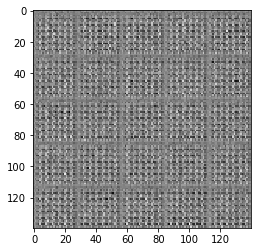

Epoch 1/2... Batch 10... Discriminator Loss: 1.3716... Generator Loss: 0.7655
Epoch 1/2... Batch 20... Discriminator Loss: 1.3835... Generator Loss: 0.6806
Epoch 1/2... Batch 30... Discriminator Loss: 1.3834... Generator Loss: 0.8077
Epoch 1/2... Batch 40... Discriminator Loss: 1.3903... Generator Loss: 0.6699
Epoch 1/2... Batch 50... Discriminator Loss: 1.3915... Generator Loss: 0.6715
Epoch 1/2... Batch 60... Discriminator Loss: 1.3924... Generator Loss: 0.6643
Epoch 1/2... Batch 70... Discriminator Loss: 1.3852... Generator Loss: 0.6991
Epoch 1/2... Batch 80... Discriminator Loss: 1.3926... Generator Loss: 0.7037
Epoch 1/2... Batch 90... Discriminator Loss: 1.3822... Generator Loss: 0.6805
Epoch 1/2... Batch 100... Discriminator Loss: 1.3842... Generator Loss: 0.7014


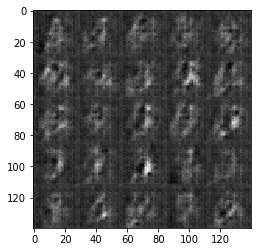

Epoch 1/2... Batch 110... Discriminator Loss: 1.3856... Generator Loss: 0.6897
Epoch 1/2... Batch 120... Discriminator Loss: 1.3877... Generator Loss: 0.6761
Epoch 1/2... Batch 130... Discriminator Loss: 1.3854... Generator Loss: 0.7006
Epoch 1/2... Batch 140... Discriminator Loss: 1.3958... Generator Loss: 0.7455
Epoch 1/2... Batch 150... Discriminator Loss: 1.3837... Generator Loss: 0.6794
Epoch 1/2... Batch 160... Discriminator Loss: 1.3771... Generator Loss: 0.7239
Epoch 1/2... Batch 170... Discriminator Loss: 1.3884... Generator Loss: 0.7047
Epoch 1/2... Batch 180... Discriminator Loss: 1.3842... Generator Loss: 0.6882
Epoch 1/2... Batch 190... Discriminator Loss: 1.3834... Generator Loss: 0.7085
Epoch 1/2... Batch 200... Discriminator Loss: 1.3882... Generator Loss: 0.6885


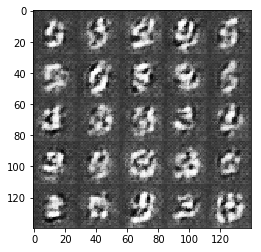

Epoch 1/2... Batch 210... Discriminator Loss: 1.3822... Generator Loss: 0.6984
Epoch 1/2... Batch 220... Discriminator Loss: 1.3855... Generator Loss: 0.6918
Epoch 1/2... Batch 230... Discriminator Loss: 1.3857... Generator Loss: 0.6886
Epoch 1/2... Batch 240... Discriminator Loss: 1.3819... Generator Loss: 0.7071
Epoch 1/2... Batch 250... Discriminator Loss: 1.3840... Generator Loss: 0.7036
Epoch 1/2... Batch 260... Discriminator Loss: 1.3813... Generator Loss: 0.6911
Epoch 1/2... Batch 270... Discriminator Loss: 1.3841... Generator Loss: 0.6758
Epoch 1/2... Batch 280... Discriminator Loss: 1.3782... Generator Loss: 0.6926
Epoch 1/2... Batch 290... Discriminator Loss: 1.3818... Generator Loss: 0.7066
Epoch 1/2... Batch 300... Discriminator Loss: 1.3803... Generator Loss: 0.6870


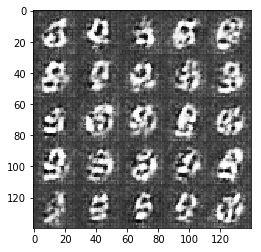

Epoch 1/2... Batch 310... Discriminator Loss: 1.3699... Generator Loss: 0.7195
Epoch 1/2... Batch 320... Discriminator Loss: 1.3788... Generator Loss: 0.7099
Epoch 1/2... Batch 330... Discriminator Loss: 1.3814... Generator Loss: 0.7057
Epoch 1/2... Batch 340... Discriminator Loss: 1.3750... Generator Loss: 0.7111
Epoch 1/2... Batch 350... Discriminator Loss: 1.3752... Generator Loss: 0.6907
Epoch 1/2... Batch 360... Discriminator Loss: 1.3775... Generator Loss: 0.7034
Epoch 1/2... Batch 370... Discriminator Loss: 1.3791... Generator Loss: 0.7006
Epoch 1/2... Batch 380... Discriminator Loss: 1.3715... Generator Loss: 0.6944
Epoch 1/2... Batch 390... Discriminator Loss: 1.3701... Generator Loss: 0.6893
Epoch 1/2... Batch 400... Discriminator Loss: 1.3761... Generator Loss: 0.6913


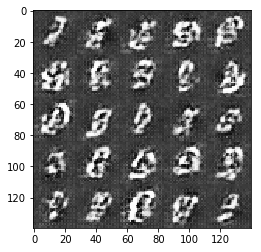

Epoch 1/2... Batch 410... Discriminator Loss: 1.3737... Generator Loss: 0.7156
Epoch 1/2... Batch 420... Discriminator Loss: 1.3750... Generator Loss: 0.6863
Epoch 1/2... Batch 430... Discriminator Loss: 1.3757... Generator Loss: 0.6972
Epoch 1/2... Batch 440... Discriminator Loss: 1.3783... Generator Loss: 0.6882
Epoch 1/2... Batch 450... Discriminator Loss: 1.3717... Generator Loss: 0.7055
Epoch 1/2... Batch 460... Discriminator Loss: 1.3738... Generator Loss: 0.7203
Epoch 1/2... Batch 470... Discriminator Loss: 1.3741... Generator Loss: 0.6932
Epoch 1/2... Batch 480... Discriminator Loss: 1.3597... Generator Loss: 0.7150
Epoch 1/2... Batch 490... Discriminator Loss: 1.3673... Generator Loss: 0.7031
Epoch 1/2... Batch 500... Discriminator Loss: 1.3666... Generator Loss: 0.7065


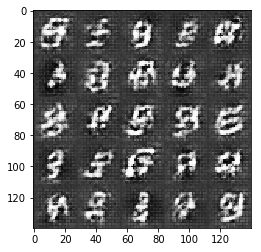

Epoch 1/2... Batch 510... Discriminator Loss: 1.3755... Generator Loss: 0.7082
Epoch 1/2... Batch 520... Discriminator Loss: 1.3655... Generator Loss: 0.6804
Epoch 1/2... Batch 530... Discriminator Loss: 1.3671... Generator Loss: 0.6771
Epoch 1/2... Batch 540... Discriminator Loss: 1.3664... Generator Loss: 0.7028
Epoch 1/2... Batch 550... Discriminator Loss: 1.3653... Generator Loss: 0.7031
Epoch 1/2... Batch 560... Discriminator Loss: 1.3686... Generator Loss: 0.7052
Epoch 1/2... Batch 570... Discriminator Loss: 1.3670... Generator Loss: 0.7115
Epoch 1/2... Batch 580... Discriminator Loss: 1.3544... Generator Loss: 0.6969
Epoch 1/2... Batch 590... Discriminator Loss: 1.3618... Generator Loss: 0.6983
Epoch 1/2... Batch 600... Discriminator Loss: 1.3622... Generator Loss: 0.7050


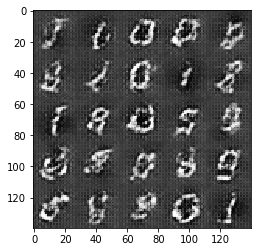

Epoch 1/2... Batch 610... Discriminator Loss: 1.3579... Generator Loss: 0.6962
Epoch 1/2... Batch 620... Discriminator Loss: 1.3617... Generator Loss: 0.6922
Epoch 1/2... Batch 630... Discriminator Loss: 1.3628... Generator Loss: 0.6954
Epoch 1/2... Batch 640... Discriminator Loss: 1.3528... Generator Loss: 0.7063
Epoch 1/2... Batch 650... Discriminator Loss: 1.3385... Generator Loss: 0.7138
Epoch 1/2... Batch 660... Discriminator Loss: 1.3582... Generator Loss: 0.7243
Epoch 1/2... Batch 670... Discriminator Loss: 1.3636... Generator Loss: 0.6892
Epoch 1/2... Batch 680... Discriminator Loss: 1.3534... Generator Loss: 0.6903
Epoch 1/2... Batch 690... Discriminator Loss: 1.3585... Generator Loss: 0.7135
Epoch 1/2... Batch 700... Discriminator Loss: 1.3623... Generator Loss: 0.7234


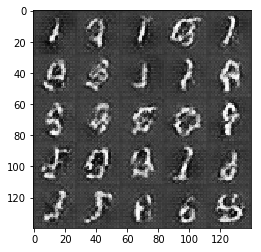

Epoch 1/2... Batch 710... Discriminator Loss: 1.3693... Generator Loss: 0.7030
Epoch 1/2... Batch 720... Discriminator Loss: 1.3458... Generator Loss: 0.7175
Epoch 1/2... Batch 730... Discriminator Loss: 1.3496... Generator Loss: 0.6942
Epoch 1/2... Batch 740... Discriminator Loss: 1.3512... Generator Loss: 0.7198
Epoch 1/2... Batch 750... Discriminator Loss: 1.3485... Generator Loss: 0.6985
Epoch 1/2... Batch 760... Discriminator Loss: 1.3464... Generator Loss: 0.7237
Epoch 1/2... Batch 770... Discriminator Loss: 1.3477... Generator Loss: 0.7217
Epoch 1/2... Batch 780... Discriminator Loss: 1.3461... Generator Loss: 0.7190
Epoch 1/2... Batch 790... Discriminator Loss: 1.3432... Generator Loss: 0.7066
Epoch 1/2... Batch 800... Discriminator Loss: 1.3606... Generator Loss: 0.6915


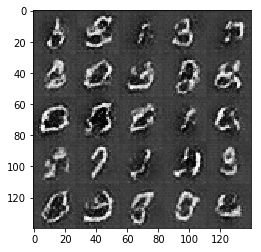

Epoch 1/2... Batch 810... Discriminator Loss: 1.3320... Generator Loss: 0.7139
Epoch 1/2... Batch 820... Discriminator Loss: 1.3542... Generator Loss: 0.6935
Epoch 1/2... Batch 830... Discriminator Loss: 1.3573... Generator Loss: 0.7114
Epoch 1/2... Batch 840... Discriminator Loss: 1.3375... Generator Loss: 0.7441
Epoch 1/2... Batch 850... Discriminator Loss: 1.3571... Generator Loss: 0.7001
Epoch 1/2... Batch 860... Discriminator Loss: 1.3533... Generator Loss: 0.6912
Epoch 1/2... Batch 870... Discriminator Loss: 1.3260... Generator Loss: 0.6894
Epoch 1/2... Batch 880... Discriminator Loss: 1.3534... Generator Loss: 0.7163
Epoch 1/2... Batch 890... Discriminator Loss: 1.3562... Generator Loss: 0.6871
Epoch 1/2... Batch 900... Discriminator Loss: 1.3145... Generator Loss: 0.7344


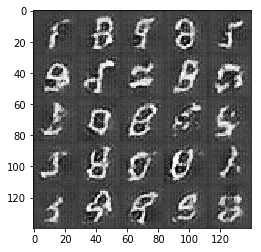

Epoch 1/2... Batch 910... Discriminator Loss: 1.3455... Generator Loss: 0.7206
Epoch 1/2... Batch 920... Discriminator Loss: 1.3401... Generator Loss: 0.7155
Epoch 1/2... Batch 930... Discriminator Loss: 1.3310... Generator Loss: 0.7033
Epoch 2/2... Batch 0... Discriminator Loss: 1.3238... Generator Loss: 0.7131


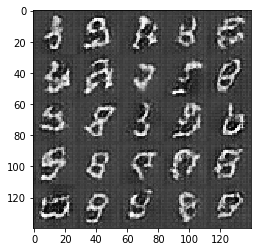

Epoch 2/2... Batch 10... Discriminator Loss: 1.3495... Generator Loss: 0.7006
Epoch 2/2... Batch 20... Discriminator Loss: 1.3384... Generator Loss: 0.7180
Epoch 2/2... Batch 30... Discriminator Loss: 1.3572... Generator Loss: 0.6710
Epoch 2/2... Batch 40... Discriminator Loss: 1.3359... Generator Loss: 0.7216
Epoch 2/2... Batch 50... Discriminator Loss: 1.3331... Generator Loss: 0.7465
Epoch 2/2... Batch 60... Discriminator Loss: 1.3270... Generator Loss: 0.7353
Epoch 2/2... Batch 70... Discriminator Loss: 1.3098... Generator Loss: 0.7405
Epoch 2/2... Batch 80... Discriminator Loss: 1.3291... Generator Loss: 0.7608
Epoch 2/2... Batch 90... Discriminator Loss: 1.3407... Generator Loss: 0.7182
Epoch 2/2... Batch 100... Discriminator Loss: 1.3304... Generator Loss: 0.7192


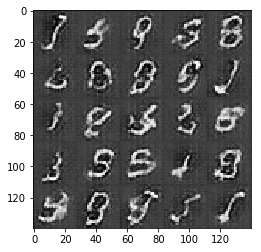

Epoch 2/2... Batch 110... Discriminator Loss: 1.3203... Generator Loss: 0.7401
Epoch 2/2... Batch 120... Discriminator Loss: 1.3421... Generator Loss: 0.7017
Epoch 2/2... Batch 130... Discriminator Loss: 1.3347... Generator Loss: 0.7435
Epoch 2/2... Batch 140... Discriminator Loss: 1.3212... Generator Loss: 0.7102
Epoch 2/2... Batch 150... Discriminator Loss: 1.3288... Generator Loss: 0.7155
Epoch 2/2... Batch 160... Discriminator Loss: 1.2833... Generator Loss: 0.7457
Epoch 2/2... Batch 170... Discriminator Loss: 1.2931... Generator Loss: 0.7293
Epoch 2/2... Batch 180... Discriminator Loss: 1.3279... Generator Loss: 0.7113
Epoch 2/2... Batch 190... Discriminator Loss: 1.3133... Generator Loss: 0.7383
Epoch 2/2... Batch 200... Discriminator Loss: 1.3385... Generator Loss: 0.7421


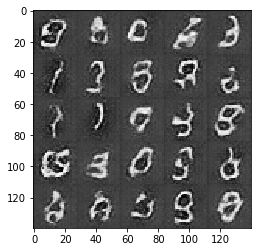

Epoch 2/2... Batch 210... Discriminator Loss: 1.2806... Generator Loss: 0.7442
Epoch 2/2... Batch 220... Discriminator Loss: 1.2817... Generator Loss: 0.7509
Epoch 2/2... Batch 230... Discriminator Loss: 1.2925... Generator Loss: 0.7970
Epoch 2/2... Batch 240... Discriminator Loss: 1.3138... Generator Loss: 0.7249
Epoch 2/2... Batch 250... Discriminator Loss: 1.3234... Generator Loss: 0.7062
Epoch 2/2... Batch 260... Discriminator Loss: 1.3283... Generator Loss: 0.7495
Epoch 2/2... Batch 270... Discriminator Loss: 1.3242... Generator Loss: 0.7095
Epoch 2/2... Batch 280... Discriminator Loss: 1.3340... Generator Loss: 0.7116
Epoch 2/2... Batch 290... Discriminator Loss: 1.2961... Generator Loss: 0.7645
Epoch 2/2... Batch 300... Discriminator Loss: 1.3080... Generator Loss: 0.7071


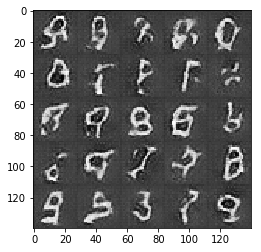

Epoch 2/2... Batch 310... Discriminator Loss: 1.3111... Generator Loss: 0.7510
Epoch 2/2... Batch 320... Discriminator Loss: 1.2731... Generator Loss: 0.7715
Epoch 2/2... Batch 330... Discriminator Loss: 1.3262... Generator Loss: 0.6980
Epoch 2/2... Batch 340... Discriminator Loss: 1.2995... Generator Loss: 0.7258
Epoch 2/2... Batch 350... Discriminator Loss: 1.2994... Generator Loss: 0.6903
Epoch 2/2... Batch 360... Discriminator Loss: 1.3226... Generator Loss: 0.7079
Epoch 2/2... Batch 370... Discriminator Loss: 1.3209... Generator Loss: 0.7325
Epoch 2/2... Batch 380... Discriminator Loss: 1.3060... Generator Loss: 0.7306
Epoch 2/2... Batch 390... Discriminator Loss: 1.3072... Generator Loss: 0.7299
Epoch 2/2... Batch 400... Discriminator Loss: 1.3105... Generator Loss: 0.6949


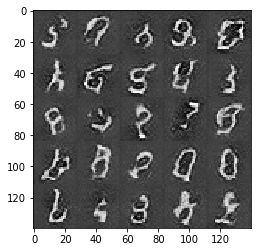

Epoch 2/2... Batch 410... Discriminator Loss: 1.3181... Generator Loss: 0.6842
Epoch 2/2... Batch 420... Discriminator Loss: 1.3141... Generator Loss: 0.7085
Epoch 2/2... Batch 430... Discriminator Loss: 1.2965... Generator Loss: 0.7565
Epoch 2/2... Batch 440... Discriminator Loss: 1.2938... Generator Loss: 0.7170
Epoch 2/2... Batch 450... Discriminator Loss: 1.2994... Generator Loss: 0.7612
Epoch 2/2... Batch 460... Discriminator Loss: 1.3099... Generator Loss: 0.7305
Epoch 2/2... Batch 470... Discriminator Loss: 1.2874... Generator Loss: 0.7588
Epoch 2/2... Batch 480... Discriminator Loss: 1.2834... Generator Loss: 0.7312
Epoch 2/2... Batch 490... Discriminator Loss: 1.3209... Generator Loss: 0.7258
Epoch 2/2... Batch 500... Discriminator Loss: 1.3143... Generator Loss: 0.7107


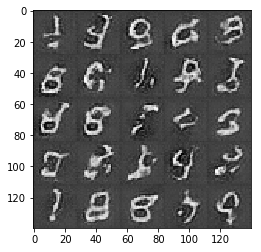

Epoch 2/2... Batch 510... Discriminator Loss: 1.3061... Generator Loss: 0.7489
Epoch 2/2... Batch 520... Discriminator Loss: 1.2956... Generator Loss: 0.8201
Epoch 2/2... Batch 530... Discriminator Loss: 1.2930... Generator Loss: 0.6942
Epoch 2/2... Batch 540... Discriminator Loss: 1.3082... Generator Loss: 0.7442
Epoch 2/2... Batch 550... Discriminator Loss: 1.3014... Generator Loss: 0.7804
Epoch 2/2... Batch 560... Discriminator Loss: 1.3104... Generator Loss: 0.7662
Epoch 2/2... Batch 570... Discriminator Loss: 1.2722... Generator Loss: 0.7315
Epoch 2/2... Batch 580... Discriminator Loss: 1.3066... Generator Loss: 0.7323
Epoch 2/2... Batch 590... Discriminator Loss: 1.3038... Generator Loss: 0.7427
Epoch 2/2... Batch 600... Discriminator Loss: 1.3295... Generator Loss: 0.7521


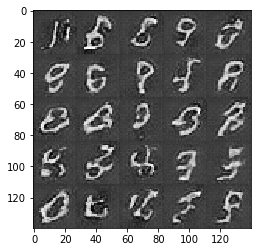

Epoch 2/2... Batch 610... Discriminator Loss: 1.2782... Generator Loss: 0.7605
Epoch 2/2... Batch 620... Discriminator Loss: 1.3060... Generator Loss: 0.7180
Epoch 2/2... Batch 630... Discriminator Loss: 1.2929... Generator Loss: 0.7337
Epoch 2/2... Batch 640... Discriminator Loss: 1.2821... Generator Loss: 0.7168
Epoch 2/2... Batch 650... Discriminator Loss: 1.2714... Generator Loss: 0.7484
Epoch 2/2... Batch 660... Discriminator Loss: 1.2558... Generator Loss: 0.7854
Epoch 2/2... Batch 670... Discriminator Loss: 1.2734... Generator Loss: 0.6774
Epoch 2/2... Batch 680... Discriminator Loss: 1.2858... Generator Loss: 0.7972
Epoch 2/2... Batch 690... Discriminator Loss: 1.2915... Generator Loss: 0.6980
Epoch 2/2... Batch 700... Discriminator Loss: 1.2896... Generator Loss: 0.7476


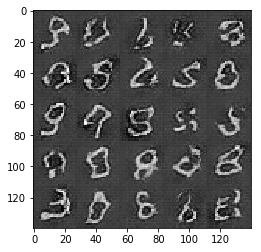

Epoch 2/2... Batch 710... Discriminator Loss: 1.2859... Generator Loss: 0.7134
Epoch 2/2... Batch 720... Discriminator Loss: 1.2588... Generator Loss: 0.7471
Epoch 2/2... Batch 730... Discriminator Loss: 1.2828... Generator Loss: 0.6829
Epoch 2/2... Batch 740... Discriminator Loss: 1.2469... Generator Loss: 0.7889
Epoch 2/2... Batch 750... Discriminator Loss: 1.2717... Generator Loss: 0.7211
Epoch 2/2... Batch 760... Discriminator Loss: 1.2895... Generator Loss: 0.8075
Epoch 2/2... Batch 770... Discriminator Loss: 1.2811... Generator Loss: 0.8149
Epoch 2/2... Batch 780... Discriminator Loss: 1.2877... Generator Loss: 0.7407
Epoch 2/2... Batch 790... Discriminator Loss: 1.2719... Generator Loss: 0.9115
Epoch 2/2... Batch 800... Discriminator Loss: 1.3126... Generator Loss: 0.6825


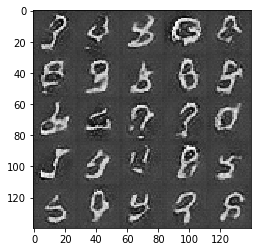

Epoch 2/2... Batch 810... Discriminator Loss: 1.2481... Generator Loss: 0.7914
Epoch 2/2... Batch 820... Discriminator Loss: 1.3045... Generator Loss: 0.6373
Epoch 2/2... Batch 830... Discriminator Loss: 1.2976... Generator Loss: 0.6996
Epoch 2/2... Batch 840... Discriminator Loss: 1.2805... Generator Loss: 0.7874
Epoch 2/2... Batch 850... Discriminator Loss: 1.2934... Generator Loss: 0.7440
Epoch 2/2... Batch 860... Discriminator Loss: 1.2274... Generator Loss: 0.8827
Epoch 2/2... Batch 870... Discriminator Loss: 1.2323... Generator Loss: 0.8341
Epoch 2/2... Batch 880... Discriminator Loss: 1.2777... Generator Loss: 0.7415
Epoch 2/2... Batch 890... Discriminator Loss: 1.2920... Generator Loss: 0.7459
Epoch 2/2... Batch 900... Discriminator Loss: 1.2601... Generator Loss: 0.7220


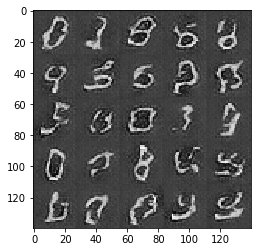

Epoch 2/2... Batch 910... Discriminator Loss: 1.2180... Generator Loss: 0.8737
Epoch 2/2... Batch 920... Discriminator Loss: 1.1984... Generator Loss: 0.8126
Epoch 2/2... Batch 930... Discriminator Loss: 1.2905... Generator Loss: 0.6569


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 0... Discriminator Loss: 1.4674... Generator Loss: 0.6206


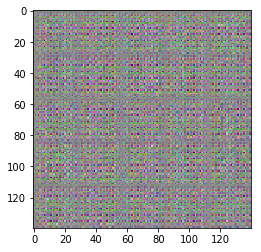

Epoch 1/1... Batch 10... Discriminator Loss: 1.3750... Generator Loss: 0.7679
Epoch 1/1... Batch 20... Discriminator Loss: 1.3879... Generator Loss: 0.7362
Epoch 1/1... Batch 30... Discriminator Loss: 1.3717... Generator Loss: 0.6905
Epoch 1/1... Batch 40... Discriminator Loss: 1.3898... Generator Loss: 0.7131
Epoch 1/1... Batch 50... Discriminator Loss: 1.4195... Generator Loss: 0.7008
Epoch 1/1... Batch 60... Discriminator Loss: 1.3737... Generator Loss: 0.6795
Epoch 1/1... Batch 70... Discriminator Loss: 1.3909... Generator Loss: 0.7201
Epoch 1/1... Batch 80... Discriminator Loss: 1.4127... Generator Loss: 0.6945
Epoch 1/1... Batch 90... Discriminator Loss: 1.3525... Generator Loss: 0.6998
Epoch 1/1... Batch 100... Discriminator Loss: 1.3432... Generator Loss: 0.7449


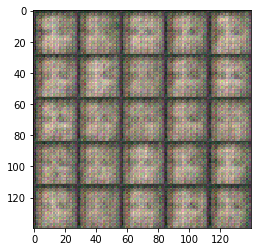

Epoch 1/1... Batch 110... Discriminator Loss: 1.3940... Generator Loss: 0.6815
Epoch 1/1... Batch 120... Discriminator Loss: 1.3498... Generator Loss: 0.7221
Epoch 1/1... Batch 130... Discriminator Loss: 1.3423... Generator Loss: 0.7488
Epoch 1/1... Batch 140... Discriminator Loss: 1.4323... Generator Loss: 0.6449
Epoch 1/1... Batch 150... Discriminator Loss: 1.3887... Generator Loss: 0.7105
Epoch 1/1... Batch 160... Discriminator Loss: 1.3682... Generator Loss: 0.6694
Epoch 1/1... Batch 170... Discriminator Loss: 1.3652... Generator Loss: 0.7635
Epoch 1/1... Batch 180... Discriminator Loss: 1.3302... Generator Loss: 0.8298
Epoch 1/1... Batch 190... Discriminator Loss: 1.3897... Generator Loss: 0.6677
Epoch 1/1... Batch 200... Discriminator Loss: 1.3417... Generator Loss: 0.7464


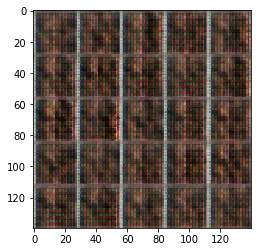

Epoch 1/1... Batch 210... Discriminator Loss: 1.4061... Generator Loss: 0.6591
Epoch 1/1... Batch 220... Discriminator Loss: 1.3585... Generator Loss: 0.6999
Epoch 1/1... Batch 230... Discriminator Loss: 1.3554... Generator Loss: 0.7742
Epoch 1/1... Batch 240... Discriminator Loss: 1.3642... Generator Loss: 0.7244
Epoch 1/1... Batch 250... Discriminator Loss: 1.4260... Generator Loss: 0.6155
Epoch 1/1... Batch 260... Discriminator Loss: 1.4076... Generator Loss: 0.6870
Epoch 1/1... Batch 270... Discriminator Loss: 1.3758... Generator Loss: 0.6599
Epoch 1/1... Batch 280... Discriminator Loss: 1.4608... Generator Loss: 0.7110
Epoch 1/1... Batch 290... Discriminator Loss: 1.3850... Generator Loss: 0.6993
Epoch 1/1... Batch 300... Discriminator Loss: 1.2953... Generator Loss: 0.8084


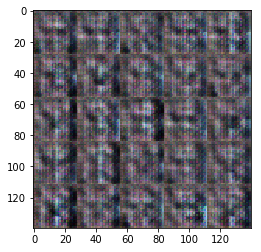

Epoch 1/1... Batch 310... Discriminator Loss: 1.3901... Generator Loss: 0.6797
Epoch 1/1... Batch 320... Discriminator Loss: 1.3851... Generator Loss: 0.6735
Epoch 1/1... Batch 330... Discriminator Loss: 1.3349... Generator Loss: 0.7675
Epoch 1/1... Batch 340... Discriminator Loss: 1.4180... Generator Loss: 0.6612
Epoch 1/1... Batch 350... Discriminator Loss: 1.3769... Generator Loss: 0.6936
Epoch 1/1... Batch 360... Discriminator Loss: 1.4136... Generator Loss: 0.6863
Epoch 1/1... Batch 370... Discriminator Loss: 1.3835... Generator Loss: 0.6819
Epoch 1/1... Batch 380... Discriminator Loss: 1.3916... Generator Loss: 0.6718
Epoch 1/1... Batch 390... Discriminator Loss: 1.4392... Generator Loss: 0.7145
Epoch 1/1... Batch 400... Discriminator Loss: 1.3878... Generator Loss: 0.6870


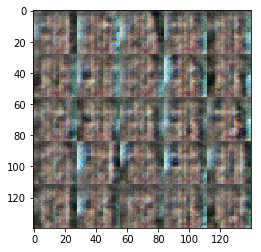

Epoch 1/1... Batch 410... Discriminator Loss: 1.4184... Generator Loss: 0.6521
Epoch 1/1... Batch 420... Discriminator Loss: 1.3786... Generator Loss: 0.7001
Epoch 1/1... Batch 430... Discriminator Loss: 1.3966... Generator Loss: 0.6951
Epoch 1/1... Batch 440... Discriminator Loss: 1.3864... Generator Loss: 0.6854
Epoch 1/1... Batch 450... Discriminator Loss: 1.3897... Generator Loss: 0.6914
Epoch 1/1... Batch 460... Discriminator Loss: 1.4075... Generator Loss: 0.6891
Epoch 1/1... Batch 470... Discriminator Loss: 1.3810... Generator Loss: 0.6926
Epoch 1/1... Batch 480... Discriminator Loss: 1.3839... Generator Loss: 0.6883
Epoch 1/1... Batch 490... Discriminator Loss: 1.3738... Generator Loss: 0.6886
Epoch 1/1... Batch 500... Discriminator Loss: 1.4171... Generator Loss: 0.6827


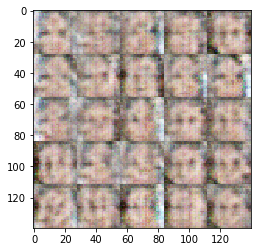

Epoch 1/1... Batch 510... Discriminator Loss: 1.3882... Generator Loss: 0.6915
Epoch 1/1... Batch 520... Discriminator Loss: 1.3565... Generator Loss: 0.7214
Epoch 1/1... Batch 530... Discriminator Loss: 1.3923... Generator Loss: 0.7150
Epoch 1/1... Batch 540... Discriminator Loss: 1.3875... Generator Loss: 0.6913
Epoch 1/1... Batch 550... Discriminator Loss: 1.3879... Generator Loss: 0.7068
Epoch 1/1... Batch 560... Discriminator Loss: 1.4029... Generator Loss: 0.6750
Epoch 1/1... Batch 570... Discriminator Loss: 1.3723... Generator Loss: 0.7060
Epoch 1/1... Batch 580... Discriminator Loss: 1.3797... Generator Loss: 0.6963
Epoch 1/1... Batch 590... Discriminator Loss: 1.3837... Generator Loss: 0.6875
Epoch 1/1... Batch 600... Discriminator Loss: 1.3676... Generator Loss: 0.7139


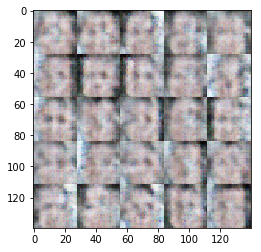

Epoch 1/1... Batch 610... Discriminator Loss: 1.3837... Generator Loss: 0.7023
Epoch 1/1... Batch 620... Discriminator Loss: 1.3846... Generator Loss: 0.6936
Epoch 1/1... Batch 630... Discriminator Loss: 1.3762... Generator Loss: 0.7128
Epoch 1/1... Batch 640... Discriminator Loss: 1.3711... Generator Loss: 0.7185
Epoch 1/1... Batch 650... Discriminator Loss: 1.3932... Generator Loss: 0.6866
Epoch 1/1... Batch 660... Discriminator Loss: 1.3856... Generator Loss: 0.6911
Epoch 1/1... Batch 670... Discriminator Loss: 1.3912... Generator Loss: 0.6800
Epoch 1/1... Batch 680... Discriminator Loss: 1.3880... Generator Loss: 0.6893
Epoch 1/1... Batch 690... Discriminator Loss: 1.3705... Generator Loss: 0.7123
Epoch 1/1... Batch 700... Discriminator Loss: 1.3863... Generator Loss: 0.7056


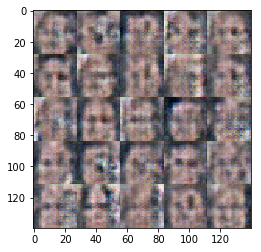

Epoch 1/1... Batch 710... Discriminator Loss: 1.3760... Generator Loss: 0.6988
Epoch 1/1... Batch 720... Discriminator Loss: 1.4089... Generator Loss: 0.7191
Epoch 1/1... Batch 730... Discriminator Loss: 1.3884... Generator Loss: 0.6895
Epoch 1/1... Batch 740... Discriminator Loss: 1.3926... Generator Loss: 0.6882
Epoch 1/1... Batch 750... Discriminator Loss: 1.3911... Generator Loss: 0.6862
Epoch 1/1... Batch 760... Discriminator Loss: 1.3888... Generator Loss: 0.6964
Epoch 1/1... Batch 770... Discriminator Loss: 1.4010... Generator Loss: 0.6636
Epoch 1/1... Batch 780... Discriminator Loss: 1.3731... Generator Loss: 0.7164
Epoch 1/1... Batch 790... Discriminator Loss: 1.3721... Generator Loss: 0.7221
Epoch 1/1... Batch 800... Discriminator Loss: 1.3712... Generator Loss: 0.7111


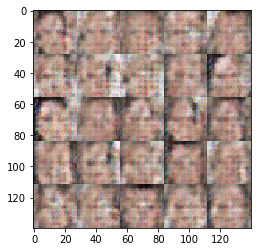

Epoch 1/1... Batch 810... Discriminator Loss: 1.4019... Generator Loss: 0.6991
Epoch 1/1... Batch 820... Discriminator Loss: 1.3803... Generator Loss: 0.6940
Epoch 1/1... Batch 830... Discriminator Loss: 1.3953... Generator Loss: 0.6969
Epoch 1/1... Batch 840... Discriminator Loss: 1.3910... Generator Loss: 0.6913
Epoch 1/1... Batch 850... Discriminator Loss: 1.3813... Generator Loss: 0.7030
Epoch 1/1... Batch 860... Discriminator Loss: 1.3838... Generator Loss: 0.6977
Epoch 1/1... Batch 870... Discriminator Loss: 1.3877... Generator Loss: 0.6904
Epoch 1/1... Batch 880... Discriminator Loss: 1.3860... Generator Loss: 0.6938
Epoch 1/1... Batch 890... Discriminator Loss: 1.3856... Generator Loss: 0.6924
Epoch 1/1... Batch 900... Discriminator Loss: 1.3832... Generator Loss: 0.6962


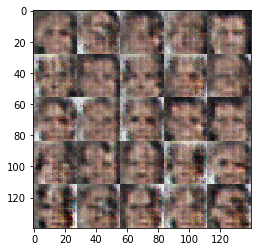

Epoch 1/1... Batch 910... Discriminator Loss: 1.3924... Generator Loss: 0.6833
Epoch 1/1... Batch 920... Discriminator Loss: 1.3860... Generator Loss: 0.6935
Epoch 1/1... Batch 930... Discriminator Loss: 1.3905... Generator Loss: 0.6886
Epoch 1/1... Batch 940... Discriminator Loss: 1.3896... Generator Loss: 0.6914
Epoch 1/1... Batch 950... Discriminator Loss: 1.3886... Generator Loss: 0.6890
Epoch 1/1... Batch 960... Discriminator Loss: 1.4155... Generator Loss: 0.6629
Epoch 1/1... Batch 970... Discriminator Loss: 1.3839... Generator Loss: 0.7030
Epoch 1/1... Batch 980... Discriminator Loss: 1.4016... Generator Loss: 0.6928
Epoch 1/1... Batch 990... Discriminator Loss: 1.3219... Generator Loss: 0.7955
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3966... Generator Loss: 0.6859


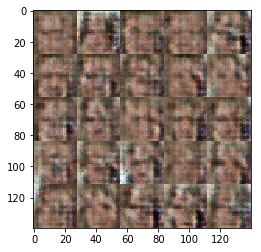

Epoch 1/1... Batch 1010... Discriminator Loss: 1.4025... Generator Loss: 0.6726
Epoch 1/1... Batch 1020... Discriminator Loss: 1.3701... Generator Loss: 0.7153
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3988... Generator Loss: 0.6963
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3856... Generator Loss: 0.7008
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3862... Generator Loss: 0.6721
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3771... Generator Loss: 0.7029
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4136... Generator Loss: 0.6785
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3637... Generator Loss: 0.7570
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3633... Generator Loss: 0.6649
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3819... Generator Loss: 0.6973


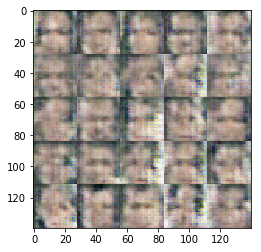

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3552... Generator Loss: 0.7621
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3708... Generator Loss: 0.6843
Epoch 1/1... Batch 1130... Discriminator Loss: 1.4159... Generator Loss: 0.6776
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3962... Generator Loss: 0.6781
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3813... Generator Loss: 0.6957
Epoch 1/1... Batch 1160... Discriminator Loss: 1.3734... Generator Loss: 0.7262
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3773... Generator Loss: 0.7056
Epoch 1/1... Batch 1180... Discriminator Loss: 1.3473... Generator Loss: 0.7062
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3931... Generator Loss: 0.6971
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3887... Generator Loss: 0.6834


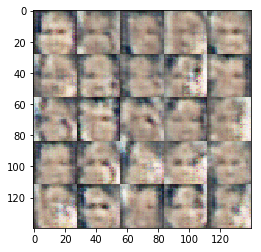

Epoch 1/1... Batch 1210... Discriminator Loss: 1.3741... Generator Loss: 0.7336
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3745... Generator Loss: 0.6862
Epoch 1/1... Batch 1230... Discriminator Loss: 1.4005... Generator Loss: 0.7369
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4281... Generator Loss: 0.6360
Epoch 1/1... Batch 1250... Discriminator Loss: 1.3863... Generator Loss: 0.6926
Epoch 1/1... Batch 1260... Discriminator Loss: 1.3932... Generator Loss: 0.6763
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3857... Generator Loss: 0.6901
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3860... Generator Loss: 0.7013
Epoch 1/1... Batch 1290... Discriminator Loss: 1.3946... Generator Loss: 0.6726
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3880... Generator Loss: 0.6932


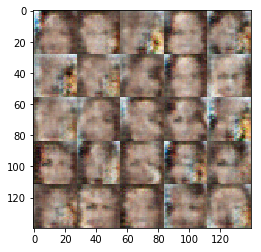

Epoch 1/1... Batch 1310... Discriminator Loss: 1.3870... Generator Loss: 0.6965
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3866... Generator Loss: 0.6977
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3876... Generator Loss: 0.6916
Epoch 1/1... Batch 1340... Discriminator Loss: 1.3878... Generator Loss: 0.6993
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3876... Generator Loss: 0.6900
Epoch 1/1... Batch 1360... Discriminator Loss: 1.3825... Generator Loss: 0.7018
Epoch 1/1... Batch 1370... Discriminator Loss: 1.3827... Generator Loss: 0.7002
Epoch 1/1... Batch 1380... Discriminator Loss: 1.3818... Generator Loss: 0.7050
Epoch 1/1... Batch 1390... Discriminator Loss: 1.3834... Generator Loss: 0.6921
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3849... Generator Loss: 0.6946


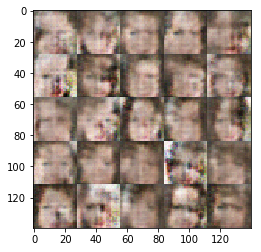

Epoch 1/1... Batch 1410... Discriminator Loss: 1.3860... Generator Loss: 0.6948
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3850... Generator Loss: 0.6893
Epoch 1/1... Batch 1430... Discriminator Loss: 1.3889... Generator Loss: 0.6852
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3890... Generator Loss: 0.6926
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3981... Generator Loss: 0.6756
Epoch 1/1... Batch 1460... Discriminator Loss: 1.3909... Generator Loss: 0.6888
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3970... Generator Loss: 0.6687
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3873... Generator Loss: 0.7015
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3858... Generator Loss: 0.6840
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3810... Generator Loss: 0.7096


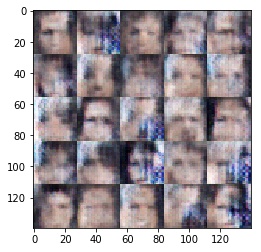

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3839... Generator Loss: 0.6914
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3909... Generator Loss: 0.6844
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3883... Generator Loss: 0.6918
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3867... Generator Loss: 0.6910
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3885... Generator Loss: 0.6983
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3858... Generator Loss: 0.6920
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3837... Generator Loss: 0.6993
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3861... Generator Loss: 0.6968
Epoch 1/1... Batch 1590... Discriminator Loss: 1.3870... Generator Loss: 0.6926
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3852... Generator Loss: 0.6984


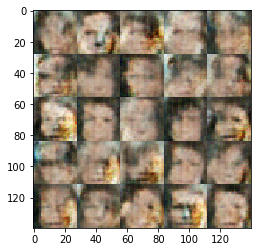

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3839... Generator Loss: 0.6977
Epoch 1/1... Batch 1620... Discriminator Loss: 1.3842... Generator Loss: 0.6997
Epoch 1/1... Batch 1630... Discriminator Loss: 1.3836... Generator Loss: 0.6981
Epoch 1/1... Batch 1640... Discriminator Loss: 1.3857... Generator Loss: 0.6962
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3858... Generator Loss: 0.6977
Epoch 1/1... Batch 1660... Discriminator Loss: 1.3857... Generator Loss: 0.6922
Epoch 1/1... Batch 1670... Discriminator Loss: 1.3852... Generator Loss: 0.6911
Epoch 1/1... Batch 1680... Discriminator Loss: 1.3875... Generator Loss: 0.6873
Epoch 1/1... Batch 1690... Discriminator Loss: 1.3858... Generator Loss: 0.6889
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3922... Generator Loss: 0.6718


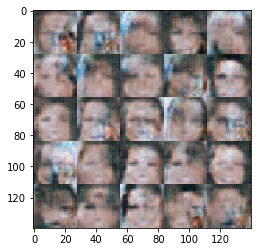

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3858... Generator Loss: 0.6945
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3888... Generator Loss: 0.6911
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3895... Generator Loss: 0.6908
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3867... Generator Loss: 0.6920
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3883... Generator Loss: 0.6899
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3876... Generator Loss: 0.6931
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3856... Generator Loss: 0.6930
Epoch 1/1... Batch 1780... Discriminator Loss: 1.3872... Generator Loss: 0.6827
Epoch 1/1... Batch 1790... Discriminator Loss: 1.3890... Generator Loss: 0.6914
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3905... Generator Loss: 0.6855


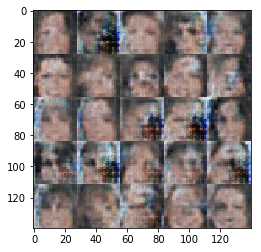

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3852... Generator Loss: 0.6904
Epoch 1/1... Batch 1820... Discriminator Loss: 1.3873... Generator Loss: 0.6961
Epoch 1/1... Batch 1830... Discriminator Loss: 1.3863... Generator Loss: 0.6940
Epoch 1/1... Batch 1840... Discriminator Loss: 1.3860... Generator Loss: 0.6967
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3848... Generator Loss: 0.6966
Epoch 1/1... Batch 1860... Discriminator Loss: 1.3854... Generator Loss: 0.6977
Epoch 1/1... Batch 1870... Discriminator Loss: 1.3852... Generator Loss: 0.7000
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3833... Generator Loss: 0.6944
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3864... Generator Loss: 0.6946
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3865... Generator Loss: 0.6896


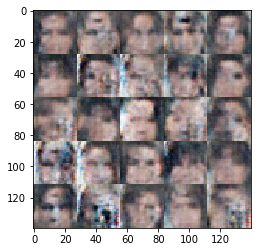

Epoch 1/1... Batch 1910... Discriminator Loss: 1.3889... Generator Loss: 0.6925
Epoch 1/1... Batch 1920... Discriminator Loss: 1.3847... Generator Loss: 0.6917
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3866... Generator Loss: 0.6941
Epoch 1/1... Batch 1940... Discriminator Loss: 1.3859... Generator Loss: 0.6911
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3841... Generator Loss: 0.6962
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3862... Generator Loss: 0.6969
Epoch 1/1... Batch 1970... Discriminator Loss: 1.3877... Generator Loss: 0.6906
Epoch 1/1... Batch 1980... Discriminator Loss: 1.3876... Generator Loss: 0.6932
Epoch 1/1... Batch 1990... Discriminator Loss: 1.3854... Generator Loss: 0.6905
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3857... Generator Loss: 0.6973


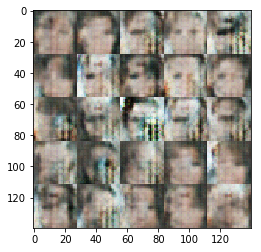

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3842... Generator Loss: 0.6956
Epoch 1/1... Batch 2020... Discriminator Loss: 1.3874... Generator Loss: 0.6933
Epoch 1/1... Batch 2030... Discriminator Loss: 1.3868... Generator Loss: 0.6936
Epoch 1/1... Batch 2040... Discriminator Loss: 1.3863... Generator Loss: 0.6903
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3867... Generator Loss: 0.6956
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3853... Generator Loss: 0.6919
Epoch 1/1... Batch 2070... Discriminator Loss: 1.3863... Generator Loss: 0.7035
Epoch 1/1... Batch 2080... Discriminator Loss: 1.3819... Generator Loss: 0.6927
Epoch 1/1... Batch 2090... Discriminator Loss: 1.3920... Generator Loss: 0.7043
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3864... Generator Loss: 0.6906


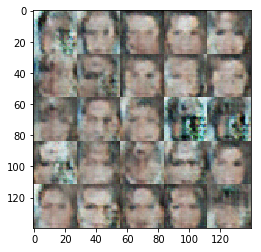

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.